In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 125

import seaborn as sns

import pandas as pd
import numpy as np
np.random.seed(0) # Giúp chạy các hàm của scikit-learn giống nhau mỗi lần chạy

import regex as re
import time # Dùng để sleep chương trình
from tqdm.notebook import tqdm # Hiện thanh progress cho đẹp :D
tqdm.pandas()

# Thư viện để request và parse HTML
import requests
from bs4 import BeautifulSoup

# Các thư viện liên quan tới ngôn ngữ và NLP
from pyvi import ViTokenizer # Thư viện NLP tiếng Việt
import gensim
import unicodedata # Thư viện unicode

# Trực quan hóa mô hình dự đoán văn bản
from lime import lime_text

# Dùng để lưu lại model
import pickle

# Thư viện liên quan của Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import feature_selection

# Tạo pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector

# Các mô hình học
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier # Phương pháp bagging

from scipy.sparse import find
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [3]:
# Thiết lập đường dẫn cho phần 1
dir_1 = "C:/Users/davin/Desktop/KHDL/"
# Thiết lập lại đường dẫn phần 1
dir_1_new = "C:/Users/davin/Desktop/KHDL/raw_data/"
# Thiết lập đường dẫn cho phần 2
dir_2 = "C:/Users/davin/Desktop/KHDL/pre_data/"
# Thiết lập đường dẫn cho phần 3
dir_3 = "C:/Users/davin/Desktop/KHDL/final_data/"
# Thiết lập đường dẫn cho phần 4
dir_4 = "C:/Users/davin/Desktop/KHDL/final_data/"

In [4]:
#TRỰC QUAN HÓA DỮ LIỆU

# Import data
df = []
for i in tqdm(range(40)):
    df.append(pd.read_csv(dir_4 + f'crawling_{i}.csv'))
    
data_df=pd.concat(df)
data_df.reset_index(drop=True, inplace=True)

  0%|          | 0/40 [00:00<?, ?it/s]

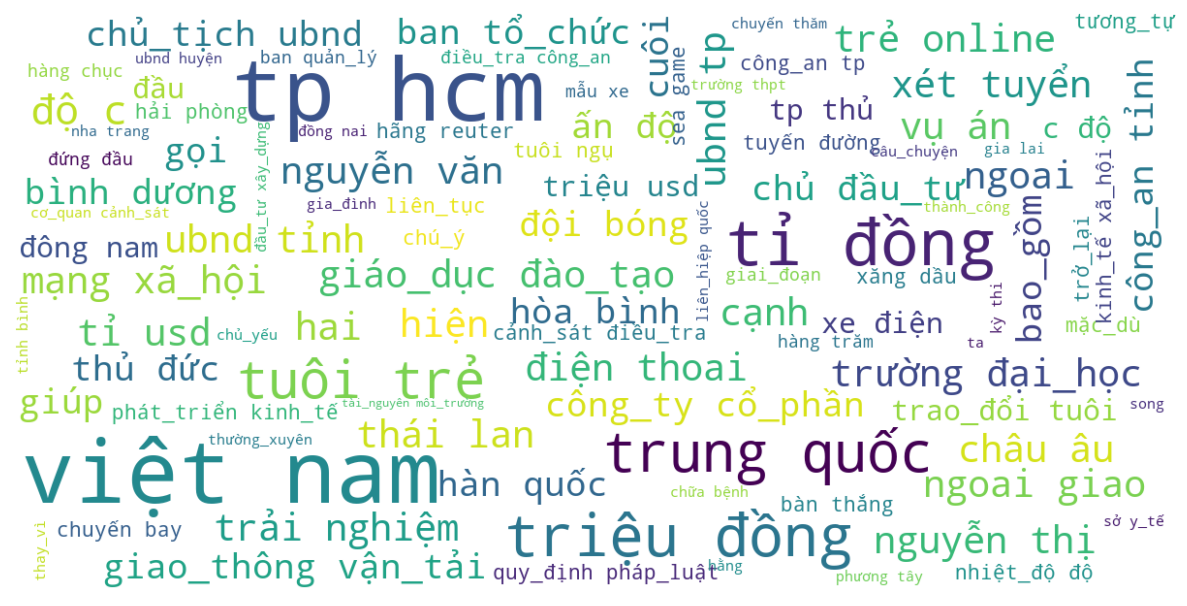

In [21]:
# Biểu đồ từ (word cloud) thể hiện tần suất xuất hiện của các từ

stopwords = set(STOPWORDS)

def show_wordcloud_from_dataframe(dataframe, column_name):
    """
    Tạo và hiển thị word cloud từ một cột của DataFrame.
    Args:
    dataframe: DataFrame chứa dữ liệu văn bản.
    column_name: Tên cột chứa văn bản.
    """
    # Kết hợp tất cả các dòng trong cột 'column_name' thành một chuỗi lớn
    text = ' '.join(dataframe[column_name].dropna().astype(str))

    # Tạo WordCloud
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1
    ).generate(text)

    # Hiển thị WordCloud
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

# Gọi hàm với DataFrame và cột 'content'
show_wordcloud_from_dataframe(data_df, 'content')

In [5]:
# tách 2 cột của dataframe
X_df = data_df["content"].astype("U")
y_sr = data_df["class"].astype("U")
#tách dữ liệu thành tập huấn luyện và tập kiếm tra
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.2, stratify=y_sr, random_state=0)

In [6]:
# Phân tích văn bản ở mức từ (word-level). Giữ lại 30,000 từ phổ biến nhất trong tập dữ liệu (dựa trên TF-IDF).
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)

# Huấn luyện bộ vector hóa trên tập huấn luyện.
train_X_tfidf =  tfidf_vect.fit_transform(train_X_df)

# Biến đổi tập kiểm tra (validation set). Tránh cung cấp thông tin về tập kiểm tra cho mô hình.
val_X_tfidf =  tfidf_vect.transform(val_X_df)

Text(0.5, 1.0, 'Sparse Matrix Sample')

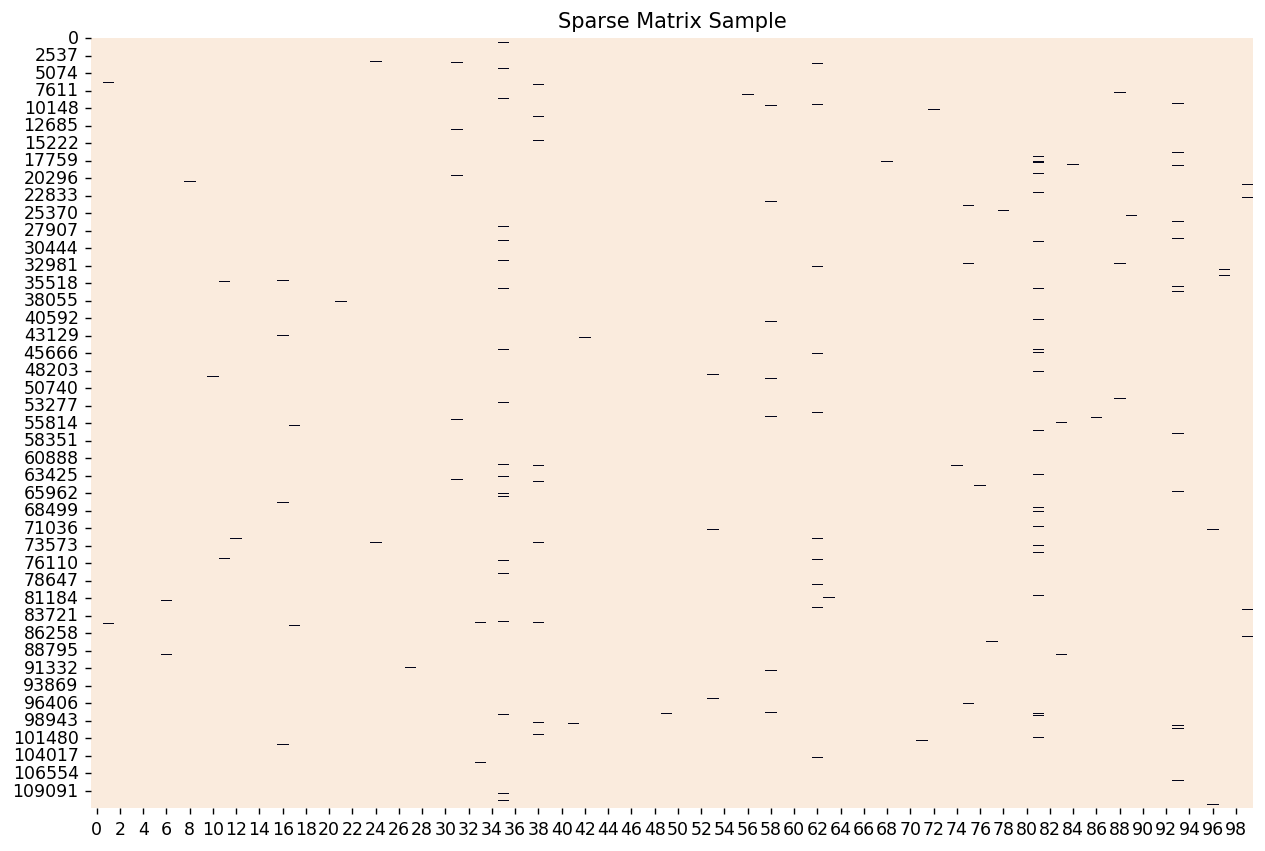

In [29]:
sns.heatmap(train_X_tfidf.todense()[:,np.random.randint(0,train_X_tfidf.shape[1],100)] == 0, cbar=False).set_title('Sparse Matrix Sample')

In [7]:
#lựa chọn đặc trưng (feature selection) dựa trên giá trị Chi-Square (Chi²) và mức ý nghĩa p-value

y = train_y_sr
X_names = tfidf_vect.get_feature_names_out() # Danh sách các đặc trưng (từ vựng)
p_value_limit = 0.95 # Ngưỡng giá trị p (1 - p-value), giữ lại các đặc trưng có ý nghĩa
dtf_features = pd.DataFrame()

for tmp in np.unique(y):
    chi2, p = feature_selection.chi2(train_X_tfidf, y==tmp)
    dtf_features = pd.concat([dtf_features, pd.DataFrame({"feature": X_names, "score": 1 - p, "y": tmp})], ignore_index=True)
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [40]:
for tmp in np.unique(y):
    print("# {}:".format(tmp))
    print("selected features:", len(dtf_features[dtf_features["y"]==tmp]))
    print("top features:", ",".join(dtf_features[dtf_features["y"]==tmp]["feature"].values[:10]))
    print(" ")

# công nghệ:
selected features: 973
top features: 2g,4g,5g,8k,acer,agi,agrawal,alphabet,altman,anthropic
 
# du lịch:
selected features: 1905
top features: agoda,alma,anh_đào,bay,benthanh,biển,booking,bãi,bãi_tắm,bảo_tồn
 
# giáo dục:
selected features: 1969
top features: a00,aisvn,apax,aptis,b00,bgdđt,biên_soạn,bách_khoa,bán_trú,bậc
 
# giải trí:
selected features: 4409
top features: aespa,ah,album,alien,all,allkpop,amee,anh_trai,anime,aquaman
 
# khoa học:
selected features: 1537
top features: advances,apollo,artemis,astrobotic,astronomy,axiom,bennu,biology,biến_đổi,băng
 
# kinh doanh:
selected features: 4661
top features: 000,500kv,9999,acb,agribank,airlines,airways,aqua,bamboo,bank
 
# pháp luật:
selected features: 3452
top features: aic,alibaba,an,ban_đầu,biên_bản,buôn_lậu,bào_chữa,bán_dâm,báo_công_an,bước_đầu
 
# sức khỏe:
selected features: 3256
top features: 108,115,19,227,alzheimer,astrazeneca,axit,b12,bhyt,biến_chủng
 
# thể thao:
selected features: 5316
top features: 100m,1

In [43]:
# Khởi tạo TfidfVectorizer với từ điển đã chọn
tfidf_vect = TfidfVectorizer(vocabulary=X_names, analyzer='word')
# Vector hóa tập huấn luyện
train_X_tfidf =  tfidf_vect.fit_transform(train_X_df)
# Vector hóa tập kiểm tra
val_X_tfidf =  tfidf_vect.transform(val_X_df)

Text(0.5, 1.0, 'Sparse Matrix Sample')

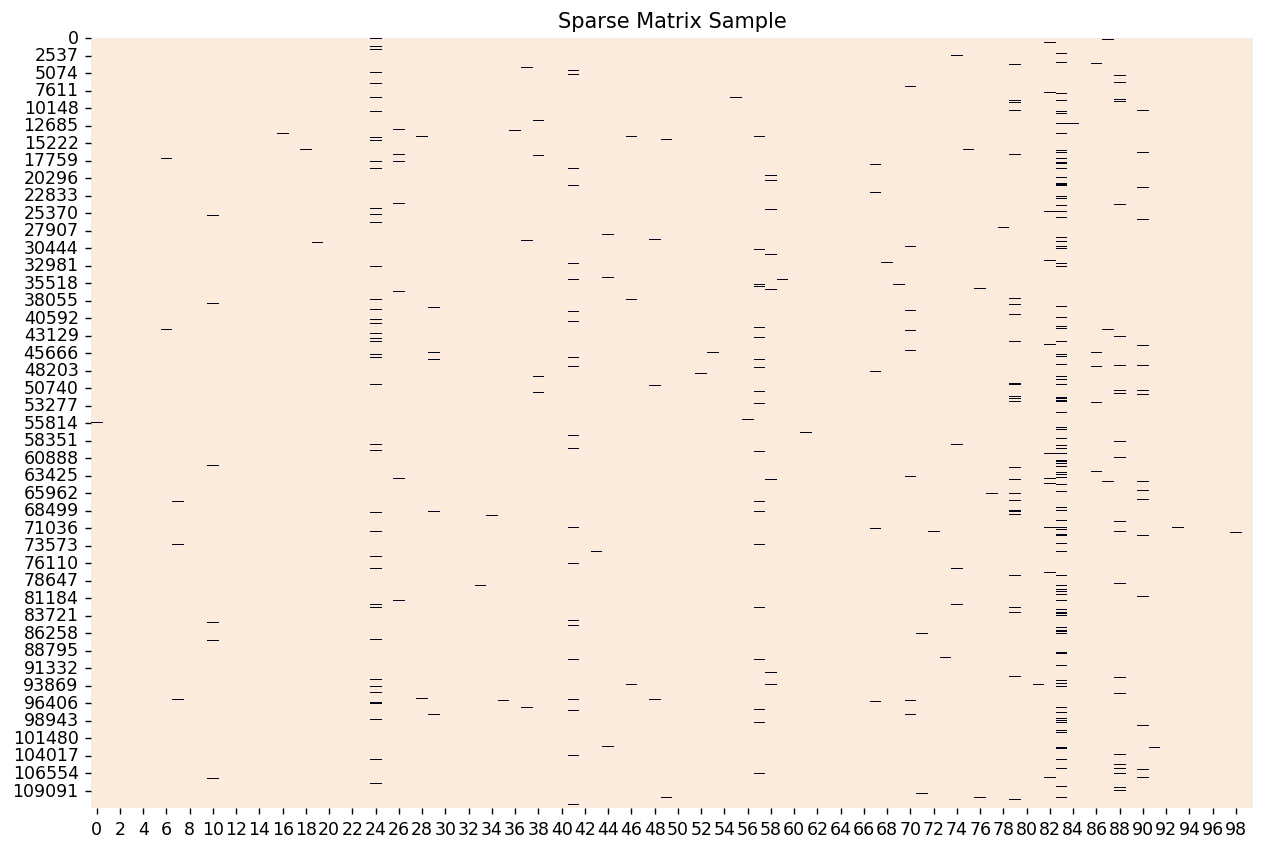

In [44]:
sns.heatmap(train_X_tfidf.todense()[:,np.random.randint(0,train_X_tfidf.shape[1],100)]==0, cbar=False).set_title('Sparse Matrix Sample')